# MPOW Data Analysis

## Imports

In [1]:
__file__

NameError: name '__file__' is not defined

In [1]:
import numpy
import os
import pandas
import plotnine as gg2
import statsmodels.api as sm
import sys
sys.path.append('/Users/jim/repos/collab/collab-mpow')
from mpow import load_data, plotting, regression
plotting.output_notebook(hide_banner=True)

## Config

In [73]:
source = load_data.Sources.Protocol

## Load data

In [74]:
data = load_data.norm_daily_data(source=source)
intraday = load_data.norm_intraday_data(source=source)
details = load_data.norm_detail_data(source=source)

In [75]:
data.head()

,Patient,DayNum,Intake,PainScore,NumObs,AgeAtAdmit,Gender,ImpairmentGroup,Depression
0,1,1,5.0,7.0,6,78,Male,Debility,1.0
1,1,2,0.0,0.0,4,78,Male,Debility,1.0
2,1,3,0.0,0.0,5,78,Male,Debility,1.0
3,1,4,0.0,0.0,6,78,Male,Debility,1.0
4,1,5,0.0,0.0,5,78,Male,Debility,1.0


## Stats

In [76]:
details.groupby(['Gender', 'Depression'])['Patient'].count().to_frame('Count').reset_index()

,Gender,Depression,Count
0,Female,0.0,26
1,Female,1.0,8
2,Male,0.0,17
3,Male,1.0,4
4,female,1.0,1


In [77]:
details.Depression.value_counts().to_frame('Count').reset_index()

,index,Count
0,0.0,43
1,1.0,13


## Explore details

### Age

Overall Distribution

In [78]:
plotting.show(plotting.histogram(details.AgeAtAdmit, bins=15))

Conditional on gender

In [79]:
details[['Gender', 'AgeAtAdmit']].groupby('Gender').median()

,AgeAtAdmit
Gender,
Female,68
Male,67
female,75


Conditional on depression

In [80]:
pandas.concat([details[details.Gender=='Male'].AgeAtAdmit.describe().to_frame('MaleAgeStats'),
details[details.Gender=='Female'].AgeAtAdmit.describe().to_frame('FemaleAgeStats')], axis=1)

,MaleAgeStats,FemaleAgeStats
count,21.000000,34.000000
mean,66.047619,65.382353
std,17.468475,14.460007
min,1.000000,20.000000
25%,61.000000,64.000000
50%,67.000000,68.000000
75%,76.000000,75.000000
max,87.000000,83.000000


In [83]:
details[['Gender', 'AgeAtAdmit', 'Depression']].groupby('Depression').median()

,AgeAtAdmit
Depression,
0.0,67
1.0,69


Conditional on impairment

In [84]:
details[['ImpairmentGroup', 'AgeAtAdmit']].groupby('ImpairmentGroup').median().sort_values('AgeAtAdmit')

,AgeAtAdmit
ImpairmentGroup,
Brain_Dysfunction,20
Stroke,51
Amputations,60
Debility,61
Spinal_Cord_Dysfunction,67
Major_Multiple_Trauma,70
Orthopaedic_Disorders,75
Cardiac,80
Neurologic_conditions,81


### Impairment

In [85]:
details.ImpairmentGroup.value_counts()

Spinal_Cord_Dysfunction    26
Orthopaedic_Disorders      15
Debility                    5
Stroke                      3
Amputations                 2
Cardiac                     2
Brain_Dysfunction           1
Neurologic_conditions       1
Major_Multiple_Trauma       1
Name: ImpairmentGroup, dtype: int64

## Depression Gender Interaction

### Model

Model: $$\LARGE{s_{t,i} \sim \beta_{0} + \beta_{1}p_{t,i} + \alpha^{df} + \alpha^{nf} + \alpha^{dm} + \alpha^{nm} + \epsilon_{t,i}}$$

### Computation

In [86]:
dgi = data.copy()
dgi['FemDep'] = ((dgi.Depression==1)&(dgi.Gender=='Female')).astype(int)
dgi['MaleDep'] = ((dgi.Depression==1)&(dgi.Gender=='Male')).astype(int)
dgi['FemNon'] = ((dgi.Depression==0)&(dgi.Gender=='Female')).astype(int)
dgi['MaleNon'] = ((dgi.Depression==0)&(dgi.Gender=='Male')).astype(int)

In [87]:
dgi_cats = {2:'FemNon',3:'MaleNon',4:'FemDep',6:'MaleDep'}
dgi_counts = (((details.Depression + 1) * ((details.Gender=='Male').astype(int) + 2))
            .to_frame('DepGenInter').applymap(dgi_cats.get))
dgi_counts.DepGenInter.value_counts()

FemNon     26
MaleNon    17
FemDep      9
MaleDep     4
Name: DepGenInter, dtype: int64

In [88]:
dgi['SexDepressionCategory'] = (1*dgi['FemDep'] + 
                                     2*dgi['MaleDep'] + 
                                     3*dgi['FemNon'] + 
                                     4*dgi['MaleNon']).apply({1:'Female Depressed    ',
                                                              2:'Male Depressed    ',
                                                              3:'Female Non-Depressed   ',
                                                              4:'Male Non-Depressed   '}.get)

In [89]:
dgi['MPS'] = dgi['PainScore'] / dgi['NumObs']

In [90]:
dgi_model = regression.ols(dgi.dropna(), ['MPS', 'FemDep', 'MaleDep', 'FemNon', 'MaleNon'], 'Intake')
dgi_model.summary()

/Users/jim/anaconda/envs/mpow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Intake   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     48.83
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           4.11e-34
Time:                        22:15:21   Log-Likelihood:                -2205.7
No. Observations:                 455   AIC:                             4421.
Df Residuals:                     450   BIC:                             4442.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2155      2.433      1.732      0.084      -0.567       8.998
MPS           11.3521      0.905     12.538      0.000       9.573      13.132
FemDep         9.2943      3.082      3.015      0.003       3.237      15.352
MaleDep        6.7427      4.496      1.500      0.134      -2.094      15.579
FemNon       -12.4644      2.263     -5.507      0.000     -16.913      -8.016
MaleNon        0.6428      2.801      0.229      0.819      -4.863       6.148
==============================================================================
Omnibus:                      225.640   Durbin-Watson:                   0.453
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1303.253
Skew:                           2.124   Prob(JB):                    1.01e-283
Kurtosis:                      10.121   Cond. No.                     3.05e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.59e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [91]:
bse = dict(dgi_model.bse)
for param, coeff in dict(dgi_model.params).items():
    print('{}:\t{:.3f}\t({:.3f}, {:.3f})'.format(param[:5], coeff, coeff - 1.96*bse[param], coeff + 1.96*bse[param]))

const:	4.216	(-0.554, 8.985)
MPS:	11.352	(9.577, 13.127)
FemDe:	9.294	(3.253, 15.335)
MaleD:	6.743	(-2.070, 15.556)
FemNo:	-12.464	(-16.901, -8.028)
MaleN:	0.643	(-4.848, 6.133)


In [92]:
dgi.head()

,Patient,DayNum,Intake,PainScore,NumObs,AgeAtAdmit,Gender,ImpairmentGroup,Depression,FemDep,MaleDep,FemNon,MaleNon,SexDepressionCategory,MPS
0,1,1,5.0,7.0,6,78,Male,Debility,1.0,0,1,0,0,Male Depressed,1.166667
1,1,2,0.0,0.0,4,78,Male,Debility,1.0,0,1,0,0,Male Depressed,0.000000
2,1,3,0.0,0.0,5,78,Male,Debility,1.0,0,1,0,0,Male Depressed,0.000000
3,1,4,0.0,0.0,6,78,Male,Debility,1.0,0,1,0,0,Male Depressed,0.000000
4,1,5,0.0,0.0,5,78,Male,Debility,1.0,0,1,0,0,Male Depressed,0.000000


In [93]:
beta0, beta1, femdep, maledep, femnon, malenon = dgi_model.params

In [94]:
beta0, beta1, femdep, maledep, femnon, malenon

(4.215533948315789,
 11.352111794388497,
 9.294318740343234,
 6.742746125291636,
 -12.464353495156791,
 0.642822577837715)

In [95]:
def dgi_estimate(p, df, nf, dm, nm):
    return beta0 + beta1*p + femdep*df + femnon*nf + maledep*dm + malenon*nm

In [96]:
ps = numpy.arange(0, 10.1, 0.1)
fit_df = pandas.concat([pandas.DataFrame({'MPS':ps, 'Intake':dgi_estimate(ps, 0, 0, 1, 0), 'DGICategory': len(ps)*['MaleDep']}),
                        pandas.DataFrame({'MPS':ps, 'Intake':dgi_estimate(ps, 0, 0, 0, 1), 'DGICategory': len(ps)*['MaleNon']}),
                        pandas.DataFrame({'MPS':ps, 'Intake':dgi_estimate(ps, 1, 0, 0, 0), 'DGICategory': len(ps)*['FemDep']}),
                        pandas.DataFrame({'MPS':ps, 'Intake':dgi_estimate(ps, 0, 1, 0, 0), 'DGICategory': len(ps)*['FemNon']})], axis=0)

In [97]:
fit_df['DataType'] = 'Fitted'

In [98]:
fit_df.head()

,MPS,Intake,DGICategory,DataType
0,0.0,10.958280,MaleDep,Fitted
1,0.1,12.093491,MaleDep,Fitted
2,0.2,13.228702,MaleDep,Fitted
3,0.3,14.363914,MaleDep,Fitted
4,0.4,15.499125,MaleDep,Fitted


In [28]:
dgi.columns

Index(['Patient', 'DayNum', 'Intake', 'PainScore', 'NumObs', 'AgeAtAdmit',
       'Gender', 'ImpairmentGroup', 'Depression', 'FemDep', 'MaleDep',
       'FemNon', 'MaleNon', 'SexDepressionCategory', 'MPS'],
      dtype='object')

In [99]:
dgi[dgi.FemDep==1][['Intake', 'PainScore']].head()

,Intake,PainScore
8,50.0,56.0
9,35.0,32.0
10,20.0,16.0
11,15.0,8.0
12,30.0,14.0


In [100]:
fit_df.head()

,MPS,Intake,DGICategory,DataType
0,0.0,10.958280,MaleDep,Fitted
1,0.1,12.093491,MaleDep,Fitted
2,0.2,13.228702,MaleDep,Fitted
3,0.3,14.363914,MaleDep,Fitted
4,0.4,15.499125,MaleDep,Fitted


### Visual

In [106]:
k = 1
fs = 15
fs2 = 10
plot = gg2.ggplot(dgi) + \
       gg2.aes(x='PainScore', y='Intake', color='SexDepressionCategory') + \
       gg2.geom_point(size=1, alpha=0.4) + \
       gg2.stat_smooth(method='lm', size=1, alpha=0.8) + \
       gg2.labs(x='Pain Score', y='Intake (oMeq)', text_size=fs) + \
       gg2.ggtitle('Opioid Intake vs. Pain Score by Sex and Depression Status [Protocol]') + \
       gg2.theme(**{
            'legend_position':'bottom', 
            'text':gg2.element_text(size=fs2),
            'plot_title':gg2.element_text(hjust=0.5, size=fs),
            'axis_text':gg2.element_text(size=fs2),
       }) 

/Users/jim/anaconda/envs/mpow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/jim/anaconda/envs/mpow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/jim/anaconda/envs/mpow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/jim/anaconda/envs/mpow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/jim/anaconda/envs/mpow/lib/python3.7/site

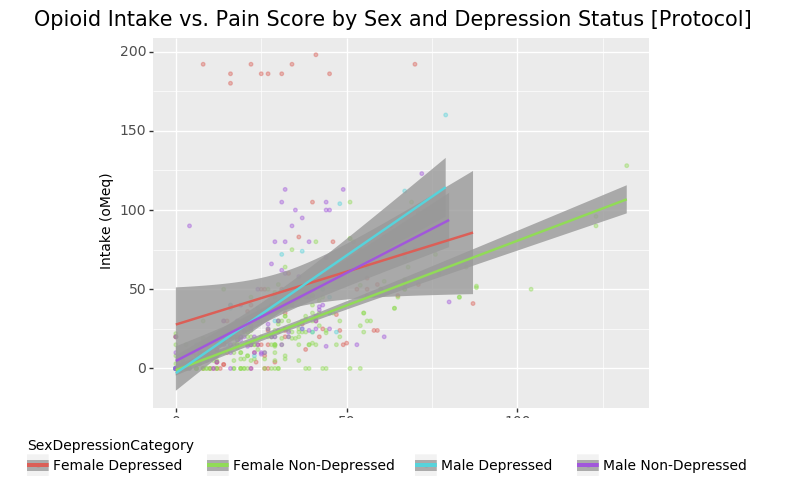

<ggplot: (7553757339)>

In [107]:
plot

In [108]:
plot.save(filename='/Users/jim/repos/collab/collab-mpow/data/img/dep-gen-interaction-proto.png',
          format='png', height=5, width=8, units='in')

/Users/jim/anaconda/envs/mpow/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 8 x 5 in image.
  from_inches(height, units), units))
/Users/jim/anaconda/envs/mpow/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: /Users/jim/repos/collab/collab-mpow/data/img/dep-gen-interaction-proto.png
  warn('Filename: {}'.format(filename))
/Users/jim/anaconda/envs/mpow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/jim/anaconda/envs/mpow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/jim/anaconda/envs/mpow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be remov